## Halotools Pipeline for SPARTA dataset ##
------------------------------------
This notebook is for carrying out the V+17 calculations (with some modification) on the Splashback Radius data provided by Benedikt Diemer.

In [1]:
# importing in all necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.recfunctions import append_fields, merge_arrays
import scipy.stats as stats
import halotools.mock_observables as mo
import halotools.sim_manager as sm
import seaborn as sns
import pandas as pd

In [2]:
# setting various properties for analysis
lbox=500.0    # size of simulation box
fixbins = 20  # number of bins we are dividing our halos among
cores = 48    # number of processor cores we are running with

# setting various constants for analysis
gnewton = 4.302e-6 # units for calculating vmax/v200b

# the dictionary of important properties of interest for the ROCKSTAR 
# read in
# format is: 'name_of_property':(column_of_property, 'formatting_code')
rs_dict = {'halo_id':(1,'i8'), 'halo_spartastatus':(80,'f8'), 
           'halo_uidsplash':(86,'i8'), 'halo_masssplash':(84,'f8'),
           'halo_uidsplash87':(96,'i8'),
           'halo_rsplash':(82, 'f8'), 'halo_mass200b':(10,'f8'), 
           'halo_r200b':(11,'f8'), 'halo_vmax':(16,'f8'),
           'halo_rs':(12,'f8'), 'halo_x':(17,'f8'), 'halo_y':(18,'f8'), 
           'halo_z':(19,'f8'), 'halo_spin':(26,'f8'),
           'halo_ctoa':(47,'f8'), 'halo_masssplash87':(99,'f8'),
           'halo_rsplash87':(97, 'f8'), 'halo_uid':(6,'i8')}

In [14]:
# We now need to read in the SPARTA catalog. The key information we need is for SPARTA to have run successfully.
# We can make cuts beyond that as we see fit.

# Location of SPARTA data.
infile = '/data/shared/sims/diemerl0500/sparta/L0500_N1024_CPla_spartahosts.catalog'

# Restrict us to the most massive halos - this rules out excess subhalos
# These likely don't exist since SPARTA cannot run on small things anyway.

minmass = 1e13 # minimum M200b halo mass in Msun/h

# Initialize the tabular reader.
reader = sm.TabularAsciiReader(infile, rs_dict, 
                               row_cut_eq_dict={'halo_spartastatus':0},
                               row_cut_min_dict={'halo_mass200b':minmass})
master_data = reader.read_ascii()


...Processing ASCII data of file: 
/data/shared/sims/diemerl0500/sparta/L0500_N1024_CPla_spartahosts.catalog
 
Total number of rows in detected data = 65697
Number of rows in detected header = 0 

... working on chunk 0 of 1
Total runtime to read in ASCII = 1.28 seconds




In [15]:
# Now we are going to add on some common 200b properties.
halo_cV200b = master_data['halo_vmax']/np.sqrt(gnewton*master_data['halo_mass200b']/master_data['halo_r200b'])
halo_cNFW200b = master_data['halo_r200b']/master_data['halo_rs']

# Also uniform randoms for our error analysis down the pipe.
uniformrands = np.random.uniform(0,1,len(master_data))

# Append these together into a master file for 200b properties.
master_data_200b = append_fields(master_data, ('halo_cV200b', 'halo_cNFW200b', 'err_rands'),
                                (halo_cV200b, halo_cNFW200b, uniformrands))

Let's do a couple of analysis plots of the underlying data. We'll need them for the paper anyway.
-----

In [16]:
# Let's put the information in a pandas dataframe so that we can use Seaborn and Pandas.
pddata = pd.DataFrame(data={'halo_M200b': master_data_200b['halo_mass200b'],
                            'halo_logM200b': np.log10(master_data_200b['halo_mass200b']),
                            'halo_r200b': master_data_200b['halo_r200b'],
                            'halo_rsp50': master_data_200b['halo_rsplash'],
                            'halo_rsp87': master_data_200b['halo_rsplash87'],
                            'halo_cNFW200b': master_data_200b['halo_cNFW200b'],
                            'halo_cV200b': master_data_200b['halo_cV200b'],
                            'halo_ctoa': master_data_200b['halo_ctoa'],
                            'halo_spin': master_data_200b['halo_spin']})

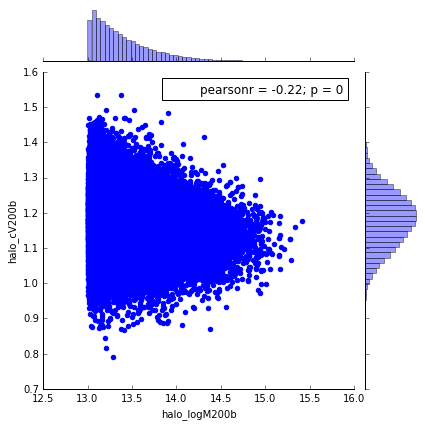

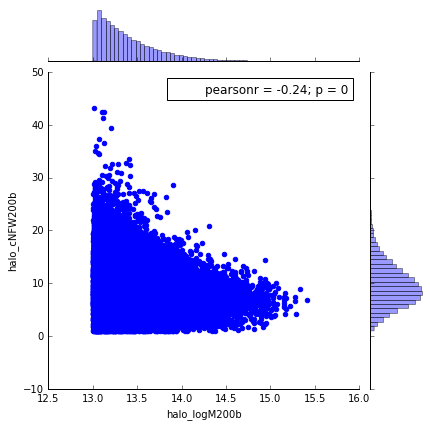

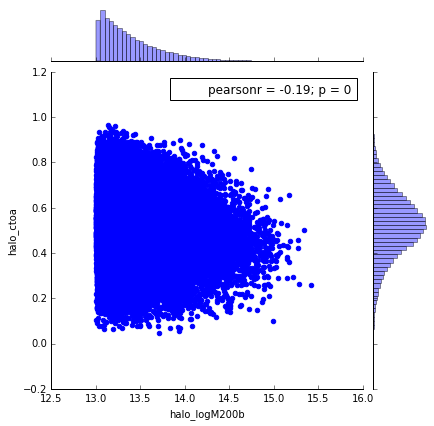

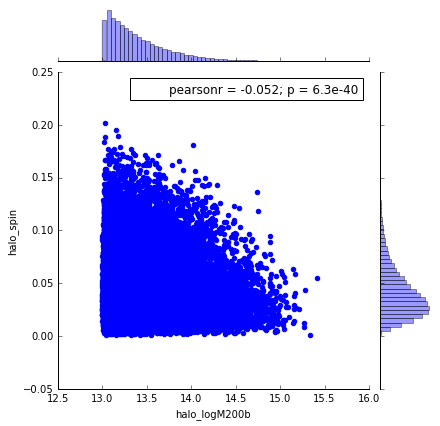

In [17]:
# One natural plot to make is to test the robustness of our halo properties. So let's look at concentration, shape, and
# spin against mass.

sns.jointplot('halo_logM200b', 'halo_cV200b', pddata)
sns.jointplot('halo_logM200b', 'halo_cNFW200b', pddata)
sns.jointplot('halo_logM200b', 'halo_ctoa', pddata)
sns.jointplot('halo_logM200b', 'halo_spin', pddata)

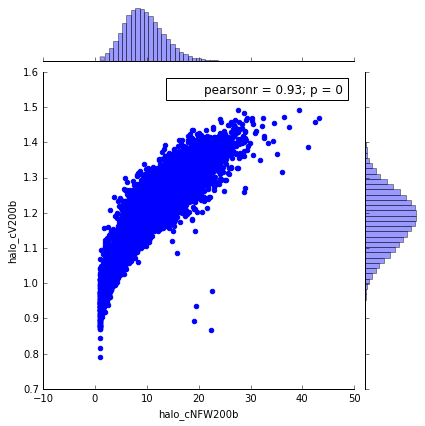

In [18]:
# And of course, comparing cNFW to cV never hurt.
sns.jointplot('halo_cNFW200b', 'halo_cV200b', pddata)

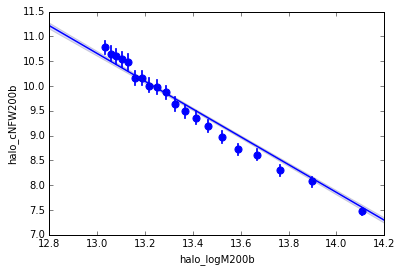

In [32]:
# First halo CNFW
sns.regplot('halo_logM200b', 'halo_cNFW200b', data=pddata, x_bins=20)

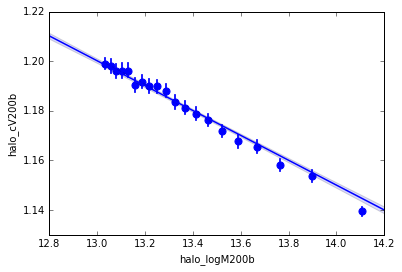

In [25]:
# Then halo cV
sns.regplot('halo_logM200b', 'halo_cV200b', data=pddata, x_bins=20)

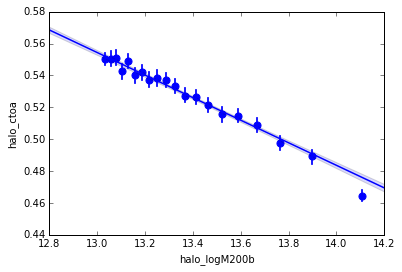

In [26]:
# Then halo shape
sns.regplot('halo_logM200b', 'halo_ctoa', data=pddata, x_bins=20)

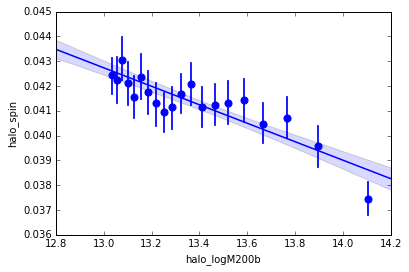

In [27]:
# Then halo spin
sns.regplot('halo_logM200b', 'halo_spin', data=pddata, x_bins=20)

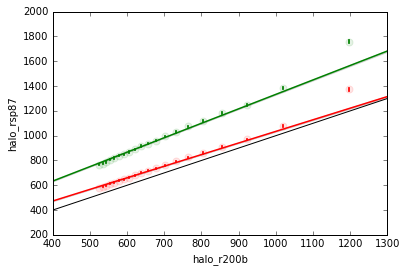

In [46]:
# And why not compare different halo radius for funsies.
sns.regplot('halo_r200b', 'halo_rsp50', data=pddata, x_bins=20, line_kws={'color':'r'}, scatter_kws={'alpha':0.1, 'color':'r'})
sns.regplot('halo_r200b', 'halo_rsp87', data=pddata, x_bins=20, line_kws={'color':'g'}, scatter_kws={'alpha':0.1, 'color':'g'})
x = range(400,1300)
plt.plot(x, x, 'k-')